In [164]:
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler
import sys
sys.path.append("/Users/Trevor1/Desktop/git/CIV_Distance/")
from CIVfunctions import project,CIV_distance

In [165]:
def plot_contour(xdata, ydata, c="k", nlevels=3, ax=None):
    if ax is None:
        ax = plt.gca()
    xmin, xmax = xdata.min(), xdata.max()
    ymin, ymax = ydata.min(), ydata.max()
    X, Y = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([xdata, ydata])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    
    #ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c)
    levels = ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c).levels
    
    for i in range(len(xdata)):
        #These are the indices of the ith's point location in Z (the density estimation) - probably the only tricky part about this
        xind = abs(X[:,0] - positions[0, abs(positions[0] - xdata[i]).argmin()]).argmin()
        yind = abs(Y[0,:] - positions[1, abs(positions[1] - ydata[i]).argmin()]).argmin()
        
        if Z[xind,yind] < levels[1]: #Plot the scatter point if it's below outermost contour level
            ax.scatter(xdata[i], ydata[i], color=c, s=10)#, label="VLA Detections")

In [2]:
!ls

AllXRayData.071221.fits               CIVDistsBokehGTR_trevor.ipynb
AllXRayData.fits                      CIV_amy_scaled_linear.npy
CIVDistBokehGTR.070521.html           CIV_amy_scaled_log.npy
CIVDistBokehGTR.html                  gamma_daox_diagonal_corrs-Copy1.ipynb
CIVDistBokehGTR_logCIVEW.html         gamma_daox_diagonal_corrs.ipynb
CIVDistsBokehGTR.070521.ipynb         gamma_vs_daox


In [3]:
df = Table.read('AllXRayData.071221.fits', format='fits')
dat = df.to_pandas()
dat.head()

,SDSS,LOGEDD_RATIO,Gamma,f2keV_ergs,L2500,Alpha_ox,Delta_Alpha_ox,New_Delta_Alpha_ox,Delg-i,Timlin_CIV_EQW,...,Old_redshift,Redshifts,HeII_EQW,LOGBH,Data_source,Clean,RA,DEC,Nardini_Sample,EV1
0,b'SDSSJ123003.80+162308.2',-0.76,1.85810,-31.759840,31.096001,-1.617769,-0.002665,-0.039064,0.116000,NaN,...,NaN,2.37464,0.393129,9.72,4,False,187.515859,16.385636,False,NaN
1,b'150313.62+575151.5 ',-0.42,2.20000,-30.648514,31.443727,-1.622615,0.061687,0.022610,-0.071669,NaN,...,1.721368,NaN,NaN,9.59,1,False,225.806747,57.864326,False,NaN
2,b'SDSSJ092513.03+363748.5',NaN,2.13456,-32.024640,30.580400,-1.456527,0.055972,0.023543,0.042000,NaN,...,NaN,2.77289,2.818198,NaN,4,False,141.304324,36.630149,False,NaN
3,b'SDSSJ135320.48+400809.8',-0.66,2.89310,-31.597590,30.796700,-1.584457,-0.028914,-0.063009,-0.095000,NaN,...,NaN,1.67258,0.651358,9.13,4,False,208.335375,40.136058,False,NaN
4,b'103151.76-013557.2 ',NaN,1.60000,-31.154761,30.838674,-1.499198,0.064698,0.030281,-0.141138,NaN,...,2.295000,2.29601,3.535803,NaN,1,False,157.965674,-1.599229,False,NaN


In [4]:
#Create a "good" mask for non-nans
blue = dat["CIV_blue"].values
gamma = dat["Gamma"].values
daox  = dat["Delta_Alpha_ox"].values
dat = dat[~np.isnan(blue)&~np.isnan(daox)&~np.isinf(gamma)]

In [5]:
gamma = dat["Gamma"].values
daox  = dat["Delta_Alpha_ox"].values
blue = dat["CIV_blue"].values
ew   = dat["CIV_EW"].values
logEW= np.log10(ew)
c4data = np.array([blue, logEW]).T
c4fit = np.load("/Users/Trevor1/Desktop/git/CIV_Distance/data/bestfit.npy")
CIVdist = CIV_distance(c4data, c4fit, step=10, path="/Users/Trevor1/Desktop/git/CIV_Distance/")

In [6]:
dat.shape

(4798, 23)

In [7]:
np.isnan(daox).sum()

0

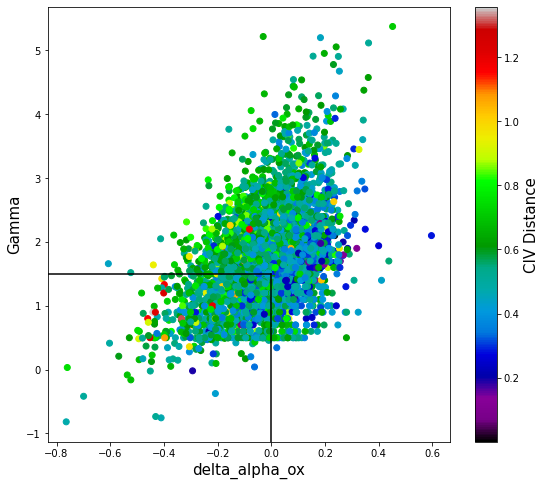

In [8]:
fig = plt.figure(figsize=(9,8))
plt.scatter(daox, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.show()

We don't know the absorption track for each individual object.  Instead we'll compute the median value of $\Delta\alpha_{ox}$ in bins of $\Gamma$

In [9]:
np.linspace(min(gamma), max(gamma), 10)

array([-0.81740999, -0.12927553,  0.55885892,  1.24699338,  1.93512784,
        2.6232623 ,  3.31139676,  3.99953122,  4.68766567,  5.37580013])

In [24]:
gamma_bins  = np.linspace(min(gamma), max(gamma), 10)
median_daox = []

for i in range(len(gamma_bins)-1):
    daox_med = np.median(daox[((gamma>=gamma_bins[i])&(gamma<gamma_bins[i+1]))])
    median_daox.append(daox_med)

In [25]:
gamma_bins_plot = gamma_bins[:-1] + ((gamma_bins[1]-gamma_bins[0])/2)

In [26]:
len(gamma_bins_plot), len(median_daox)

(9, 9)

In [27]:
median_daox

[-0.47689035237548794,
 -0.185379445025,
 -0.0936913906838,
 -0.020073588046874313,
 0.01901885312345827,
 0.05964431596557507,
 0.10319492700256383,
 0.12230250718750035,
 0.21465167623962467]

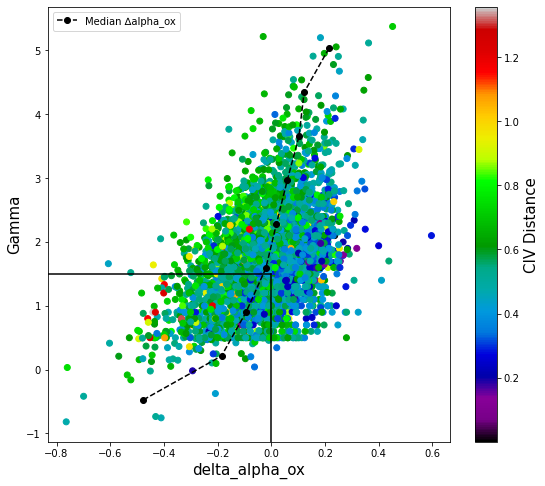

In [77]:
fig = plt.figure(figsize=(9,8))
plt.scatter(daox, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
plt.plot(median_daox, gamma_bins_plot, "--o", color="k", label="Median ∆alpha_ox")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.legend(loc="best")
plt.show()

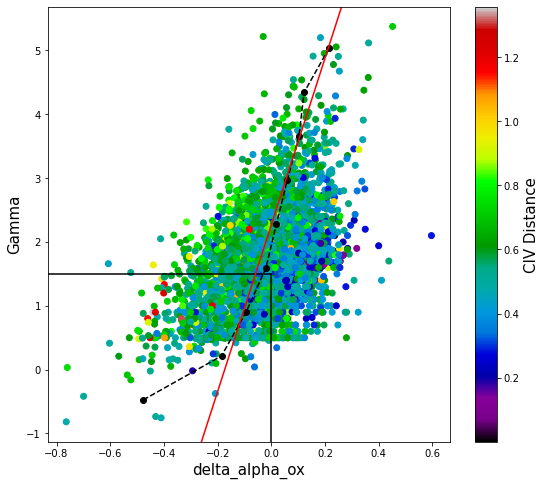

In [132]:
m,b = np.polyfit(median_daox[1:], gamma_bins_plot[1:], 1)
x = np.linspace(-0.6, 0.35, 10000)
y = m*x + b

fig = plt.figure(figsize=(9,8))
plt.scatter(daox, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
plt.plot(median_daox, gamma_bins_plot, "--o", color="k")
plt.plot(x,y,"-r")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.show()

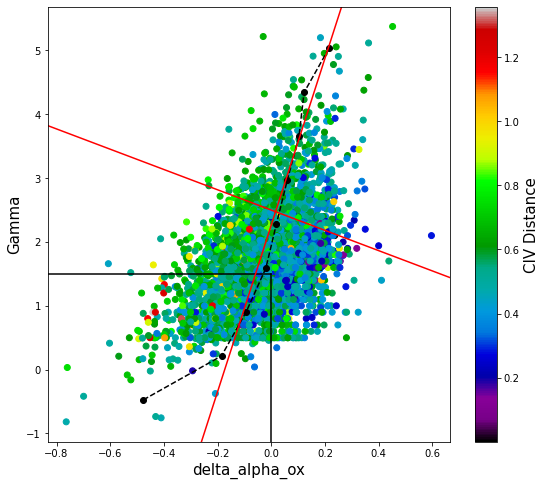

In [133]:
#Manually define perpendicular axis in unscaled space
mm, bb = -1.5885, 2.5
xx = np.linspace(-0.9, 0.7, 10000)
yy = mm*xx + bb

fig = plt.figure(figsize=(9,8))
plt.scatter(daox, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
plt.plot(median_daox, gamma_bins_plot, "--o", color="k")
plt.plot(x,y,"-r")
plt.plot(xx,yy,"-r")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.show()

Now want to make the red lines the axes of the "primed" coordinates.  

In [134]:
from sklearn.preprocessing import MinMaxScaler

1) Scale data

In [135]:
#Format raw data
data = np.array([daox,gamma]).T
yaxp = np.array([x,y]).T
xaxp = np.array([xx,yy]).T
med_daox = np.array([median_daox, gamma_bins_plot]).T

#Scaled data
scaler = MinMaxScaler().fit(data)
data_scaled = scaler.transform(data)
yaxp_scaled = scaler.transform(yaxp)
xaxp_scaled = scaler.transform(xaxp)
med_daox_scaled = scaler.transform(med_daox)

In [136]:
def slope(line):
    return (line[2,1]-line[1,1]) / (line[2,0]-line[1,0])

slope(yaxp_scaled)*slope(xaxp_scaled)

-1.0008582454019446

^ Should equal -1 for perpendicular in scaled space.  Can maybe fit for this in a final version.

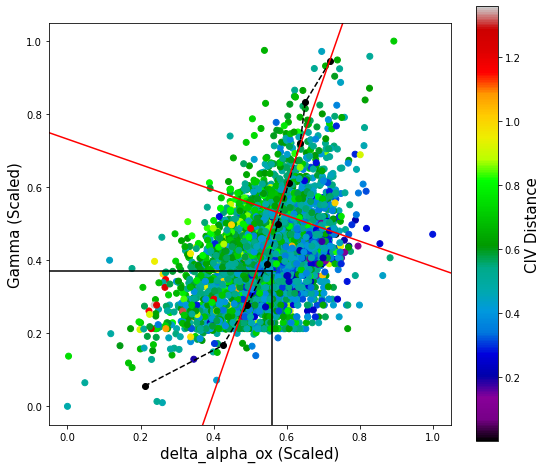

In [137]:
#Plot in scaled coordinates
fig = plt.figure(figsize=(9,8))
plt.scatter(data_scaled[:,0], data_scaled[:,1], c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0.56],[0.37,0.37], "-k") #manual placement of box
plt.plot([0.56,0.56],[ylims[0],0.37], "-k")
plt.plot(med_daox_scaled[:,0],med_daox_scaled[:,1], "--o", color="k")
plt.plot(yaxp_scaled[:,0],yaxp_scaled[:,1],"-r")
plt.plot(xaxp_scaled[:,0],xaxp_scaled[:,1],"-r")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims)
plt.xlim(xlims)
plt.ylabel("Gamma (Scaled)", fontsize=15)
plt.xlabel("delta_alpha_ox (Scaled)", fontsize=15)
plt.gca().set_aspect("equal")
plt.show()

In [138]:
#This is how we'll revert back to raw space
data_raw = scaler.inverse_transform(data_scaled)
yaxp_raw = scaler.inverse_transform(yaxp_scaled)
xaxp_raw = scaler.inverse_transform(xaxp_scaled)
med_daox_raw = scaler.inverse_transform(med_daox_scaled)

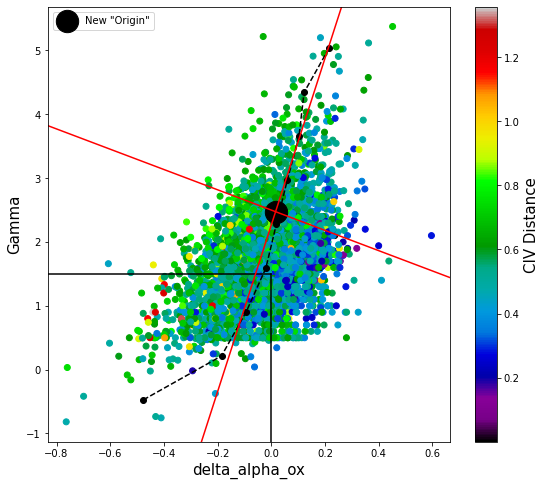

In [139]:
#Plot in scaled coordinates
fig = plt.figure(figsize=(9,8))
plt.scatter(data_raw[:,0], data_raw[:,1], c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
plt.plot(med_daox_raw[:,0],med_daox_raw[:,1], "--o", color="k")
plt.plot(yaxp_raw[:,0],yaxp_raw[:,1],"-r")
plt.plot(xaxp_raw[:,0],xaxp_raw[:,1],"-r")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)

#Plot intersection point
intx, inty = line_intersection(xaxp_raw, yaxp_raw)
plt.scatter(intx, inty, s=500, c="k", label='New "Origin"')

plt.ylim(ylims)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
#plt.gca().set_aspect("equal")
plt.legend(loc="best")
plt.show()

First, find each point's distance from the new y axis.  Then plot against CIV distance to see how much we can shift each point toward that axis based on its measured CIV distance.

The distance is:

$$ r_i = \min{ \sqrt{ ({\bf x_\mathrm{line}} - x_i)^2 + ({\bf y_\mathrm{line}} - y_i)^2 } } $$

And the unit vector pointing along the orthogonal projection of the the point onto the curve gives the direction to shift:

$$ \hat{\bf r}_i = \frac{( x_\mathrm{line,min} - x_i, y_\mathrm{line,min} - y_i )}{r_i} $$

So if the original position of the data is ${\bf x}$, then its position along the new y axis ${\bf x}'$ is given by:

$$ {\bf x}' = r_i\hat{\bf r}_i $$

In this, we'll fit for $r_i$ as a function of CIV distance.

In [141]:
def line_intersection(line1, line2):
    #Only care about the endpoints
    line1 = ( (line1[0,0], line1[0,1]), (line1[-1,0], line1[-1,1]) )
    line2 = ( (line2[0,0], line2[0,1]), (line2[-1,0], line2[-1,1]) )
    
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

print(line_intersection(xaxp_raw, yaxp_raw))

(0.01605903287843459, 2.4744902262726067)


In [142]:
def project_pt(pt, fit):
    #Get distance^2 of point from line - minimum
    r2 = (pt[1]-fit[:,1])**2 + (pt[0]-fit[:,0])**2
    return [ fit[r2.argmin(),0], fit[r2.argmin(),1] ]

In [146]:
def diag_shift(data, xax, yax):
    #Find the *distance* of each point from the line -- save the index of that point as well
    disty = []
    distx = []
    abs_disty = []
    abs_distx = []
    int_x, int_y = line_intersection(xax, yax) #intersection of the two new axes (the "origin")
    
    for i in range(len(data)):
        r_y = np.sqrt( (data[i,0] - yax[:,0])**2 + (data[i,1] - yax[:,1])**2 )
        r_x = np.sqrt( (data[i,0] - xax[:,0])**2 + (data[i,1] - xax[:,1])**2 )
        ind_yax = r_y.argmin()
        ind_xax = r_x.argmin()
        abs_disty.append(min(r_y)) ; abs_distx.append(min(r_x))
        
        #Get which side the of the line the point is on so we can have negative distances
        proj_x = project_pt(data[i,:], xax)
        side_y = 1 if (proj_x[0]>=int_x) else -1
        disty.append(side_y*min(r_y))
        
    return np.array(disty)

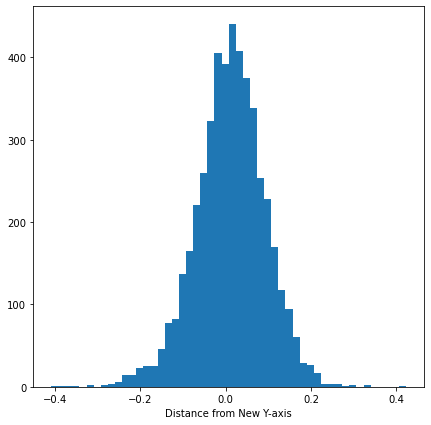

0.013570429339714444


In [208]:
perp_dist_y = diag_shift(data_scaled, xaxp_scaled, yaxp_scaled)
fig = plt.figure(figsize=(7,7))
plt.hist(perp_dist_y, bins="scott")
plt.xlabel("Distance from New Y-axis")
plt.show()
print(np.median(perp_dist_y))

Now plot $\perp$ distance versus CIV distance

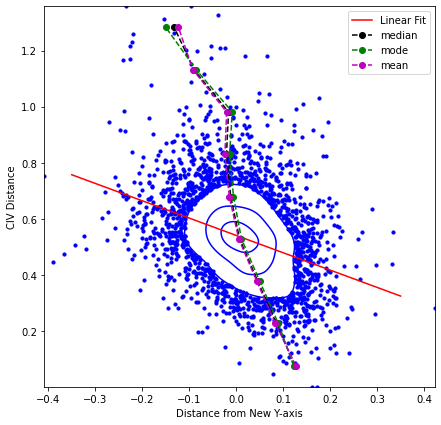

In [166]:
m, b = np.polyfit(perp_dist_y, CIVdist, 1)
x = np.linspace(-0.35, 0.35, 100)
y = m*x + b

#Find medians in bins of CIV distance
CIVdist_bins  = np.linspace(min(CIVdist), max(CIVdist), 10)
median_perpdist = []
mode_perpdist = []
mean_perpdist = []
for i in range(len(CIVdist_bins)-1):
    perpdist_med = np.median(perp_dist_y[((CIVdist>=CIVdist_bins[i])&(CIVdist<CIVdist_bins[i+1]))])
    perpdist_mode = 3*np.median(perp_dist_y[((CIVdist>=CIVdist_bins[i])&(CIVdist<CIVdist_bins[i+1]))]) - 2*np.mean(perp_dist_y[((CIVdist>=CIVdist_bins[i])&(CIVdist<CIVdist_bins[i+1]))])
    perpdist_mean = np.mean(perp_dist_y[((CIVdist>=CIVdist_bins[i])&(CIVdist<CIVdist_bins[i+1]))])
    median_perpdist.append(perpdist_med)
    mode_perpdist.append(perpdist_mode)
    mean_perpdist.append(perpdist_mean)
CIVdist_bins_plot = CIVdist_bins[:-1] + ((CIVdist_bins[1]-CIVdist_bins[0])/2)

fig = plt.figure(figsize=(7,7))
#plt.scatter(perp_dist_y, CIVdist)
plot_contour(perp_dist_y, CIVdist, c="b", nlevels=3)
plt.plot(x, y, "-r", label="Linear Fit")
plt.plot(median_perpdist, CIVdist_bins_plot, "--o", c="k", label="median")
plt.plot(mode_perpdist, CIVdist_bins_plot, "--o", c="g", label="mode")
plt.plot(mean_perpdist, CIVdist_bins_plot, "--o", c="m", label="mean")
plt.ylabel("CIV Distance")
plt.xlabel("Distance from New Y-axis")
plt.legend(loc="best")
plt.show()

Which track to take?  Almost looks like average of both would be better.

Better to just shift points along the above x-axis or rotate the distribution so it's centered at 0.0?  (Or both?)

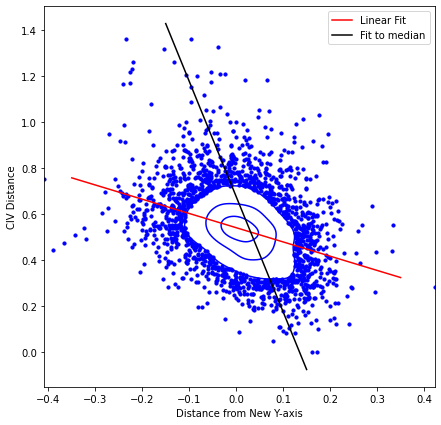

In [167]:
#get fit to median
m_med, b_med = np.polyfit(median_perpdist, CIVdist_bins_plot, 1)
x_med = np.linspace(-0.15, 0.15, 500)
y_med = m_med*x_med + b_med

fig = plt.figure(figsize=(7,7))
#plt.scatter(perp_dist_y, CIVdist)
plot_contour(perp_dist_y, CIVdist, c="b", nlevels=3)
plt.plot(x, y, "-r", label="Linear Fit")
#plt.plot(median_perpdist, CIVdist_bins_plot, "--o", c="k", label="median")
plt.plot(x_med, y_med, "-k", label="Fit to median")
plt.ylabel("CIV Distance")
plt.xlabel("Distance from New Y-axis")
plt.legend(loc="best")
plt.show()

In [170]:
m_avg = ( m + m_med ) / 2
#Now, given where the two lines intersect, what is the corresponding y-intercept?
fit_lin = np.array([x,y]).T
fit_med = np.array([x_med,y_med]).T
intfit_x, intfit_y = line_intersection(fit_lin, fit_med)
b_avg = intfit_y - intfit_x*m_avg

x_avg = np.linspace(-0.15, 0.15, 500)
y_avg = m_avg*x_avg + b_avg

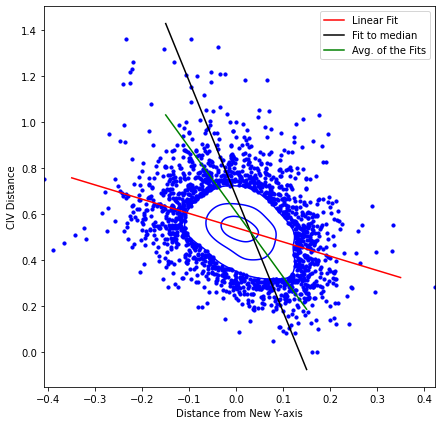

In [172]:
fig = plt.figure(figsize=(7,7))
#plt.scatter(perp_dist_y, CIVdist)
plot_contour(perp_dist_y, CIVdist, c="b", nlevels=3)
plt.plot(x, y, "-r", label="Linear Fit")
#plt.plot(median_perpdist, CIVdist_bins_plot, "--o", c="k", label="median")
plt.plot(x_med, y_med, "-k", label="Fit to median")
plt.plot(x_avg, y_avg, "-g", label="Avg. of the Fits")
plt.ylabel("CIV Distance")
plt.xlabel("Distance from New Y-axis")
plt.legend(loc="best")
plt.show()

Ah, right -- for the average we're looking for, that would be in a scaled space.

In [173]:
perp_civ_data = np.array([perp_dist_y, CIVdist]).T
scaler_civ = MinMaxScaler().fit(perp_civ_data)
perp_civ_data_scaled = scaler_civ.transform(perp_civ_data)

In [174]:
perp_dist_y_scaled = perp_civ_data_scaled[:,0]
CIVdist_scaled = perp_civ_data_scaled[:,1]

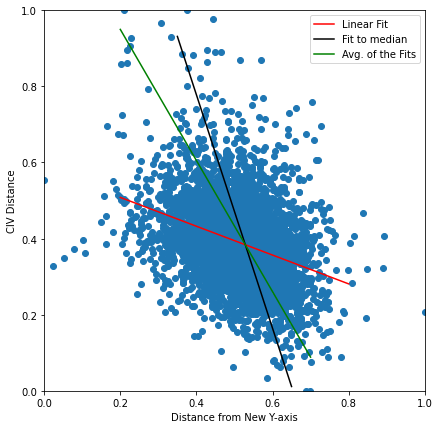

In [195]:
m_scaled, b_scaled = np.polyfit(perp_dist_y_scaled, CIVdist_scaled, 1)
x_scaled = np.linspace(0.2, 0.8, 500)
y_scaled = m_scaled*x_scaled + b_scaled

#Find medians in bins of CIV distance
CIVdist_bins_scaled  = np.linspace(min(CIVdist_scaled), max(CIVdist_scaled), 10)
median_perpdist_scaled = []
for i in range(len(CIVdist_bins_scaled)-1):
    perpdist_med_scaled = np.median(perp_dist_y_scaled[((CIVdist_scaled>=CIVdist_bins_scaled[i])&(CIVdist_scaled<CIVdist_bins_scaled[i+1]))])
    median_perpdist_scaled.append(perpdist_med_scaled)
CIVdist_bins_plot_scaled = CIVdist_bins_scaled[:-1] + ((CIVdist_bins_scaled[1]-CIVdist_bins_scaled[0])/2)

#get fit to median
m_med_scaled, b_med_scaled = np.polyfit(median_perpdist_scaled, CIVdist_bins_plot_scaled, 1)
x_med_scaled = np.linspace(0.35, 0.65, 500)
y_med_scaled = m_med_scaled*x_med_scaled + b_med_scaled

m_avg_scaled = ( m_scaled + m_med_scaled ) / 2
#Now, given where the two lines intersect, what is the corresponding y-intercept?
fit_lin_scaled = np.array([x_scaled,y_scaled]).T
fit_med_scaled = np.array([x_med_scaled,y_med_scaled]).T
intfit_x_scaled, intfit_y_scaled = line_intersection(fit_lin_scaled, fit_med_scaled)
b_avg_scaled = intfit_y_scaled - intfit_x_scaled*m_avg_scaled

x_avg_scaled = np.linspace(0.2, 0.7, 500)
y_avg_scaled = m_avg_scaled*x_avg_scaled + b_avg_scaled

fig = plt.figure(figsize=(7,7))
plt.scatter(perp_dist_y_scaled, CIVdist_scaled)
#plot_contour(perp_dist_y_scaled, CIVdist_scaled, c="b", nlevels=3)
plt.plot(x_scaled, y_scaled, "-r", label="Linear Fit")
#plt.plot(median_perpdist_scaled, CIVdist_bins_plot_scaled, "--o", c="k", label="median")
plt.plot(x_med_scaled, y_med_scaled, "-k", label="Fit to median")
plt.plot(x_avg_scaled, y_avg_scaled, "-g", label="Avg. of the Fits")
plt.ylabel("CIV Distance")
plt.xlabel("Distance from New Y-axis")
plt.legend(loc="best")
plt.ylim(0,1)
plt.xlim(0,1)
plt.gca().set_aspect("equal")
plt.show()

In [192]:
(y_avg_scaled[1]-y_avg_scaled[0])/(x_avg_scaled[1]-x_avg_scaled[0]), (y_med_scaled[1]-y_med_scaled[0])/(x_med_scaled[1]-x_med_scaled[0]), (y_scaled[1]-y_scaled[0])/(x_scaled[1]-x_scaled[0])

(-1.722669184101029, -3.066641607907415, -0.3786967602946238)

In [191]:
m_avg_scaled

-1.7226691841011026

So we are getting the average of the slopes, but that's not actually what we want.  The angle $\phi$ between two slopes $m_1$ and $m_2$ is 

$$ \phi = \tan^{-1}(\frac{m_1-m_2}{1+m_1m_2}). $$

What we want is another slope $\tilde{m}$ which forms an angle $\phi/2$ with the two original slopes.  Solving the above gives:

$$ \tilde{m} = \frac{m_1 - \tan(\phi/2)}{1+m_1\tan(\phi/2)} $$

I think now there was actually no need to move to a second scaled space.

In [225]:
np.arctan(np.inf)

1.5707963267948966

In [219]:
phi = np.arctan((m_scaled-m_med_scaled)/(1+m_scaled*m_med_scaled))
m_new_scaled = (m_scaled-np.tan(phi/2)) / (1+m_scaled*np.tan(phi/2))
b_new_scaled = intfit_y_scaled - intfit_x_scaled*m_new_scaled
x_new_scaled = np.linspace(-0.1, 1, 1000)
y_new_scaled = m_new_scaled*x_new_scaled + b_new_scaled

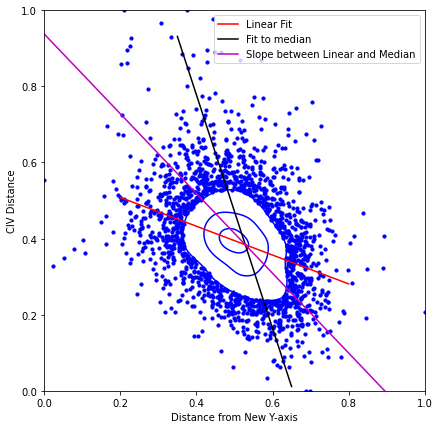

In [213]:
fig = plt.figure(figsize=(7,7))
#plt.scatter(perp_dist_y_scaled, CIVdist_scaled)
plot_contour(perp_dist_y_scaled, CIVdist_scaled, c="b", nlevels=3)
plt.plot(x_scaled, y_scaled, "-r", label="Linear Fit")
#plt.plot(median_perpdist_scaled, CIVdist_bins_plot_scaled, "--o", c="k", label="median")
plt.plot(x_med_scaled, y_med_scaled, "-k", label="Fit to median")
#plt.plot(x_avg_scaled, y_avg_scaled, "-g", label="Avg. of the Fits")
plt.plot(x_new_scaled, y_new_scaled, "-m", label="Slope between Linear and Median")
plt.ylabel("CIV Distance")
plt.xlabel("Distance from New Y-axis")
plt.legend(loc="best")
plt.ylim(0,1)
plt.xlim(0,1)
plt.gca().set_aspect("equal")
plt.show()

Maybe looks slightly off for some reason (but not enough for the math to be wrong?)?  Nevertheless, that's what we wanted.

See if this will work in the unscaled space:

In [220]:
phi = np.arctan((m-m_med)/(1+m*m_med))
m_new = (m-np.tan(phi/2)) / (1+m*np.tan(phi/2))
b_new = intfit_y - intfit_x*m_new
x_new = np.linspace(-0.35, 0.35, 100)
y_new = m_new*x_new + b_new

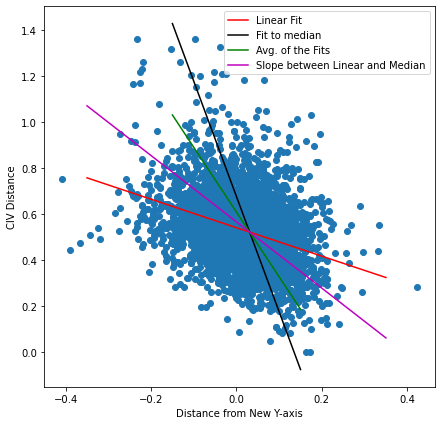

In [215]:
fig = plt.figure(figsize=(7,7))
plt.scatter(perp_dist_y, CIVdist)
#plot_contour(perp_dist_y, CIVdist, c="b", nlevels=3)
plt.plot(x, y, "-r", label="Linear Fit")
#plt.plot(median_perpdist, CIVdist_bins_plot, "--o", c="k", label="median")
plt.plot(x_med, y_med, "-k", label="Fit to median")
plt.plot(x_avg, y_avg, "-g", label="Avg. of the Fits")
plt.plot(x_new, y_new, "-m", label="Slope between Linear and Median")
plt.ylabel("CIV Distance")
plt.xlabel("Distance from New Y-axis")
plt.legend(loc="best")
plt.show()

No -- this needs to be done in the scaled coordinates.  Inverse transform the fit into raw space and get corrections that we'll want to apply.

In [221]:
fit_civ_final_scaled = np.array([x_new_scaled,y_new_scaled]).T
fit_civ_final = scaler_civ.inverse_transform(fit_civ_final_scaled)

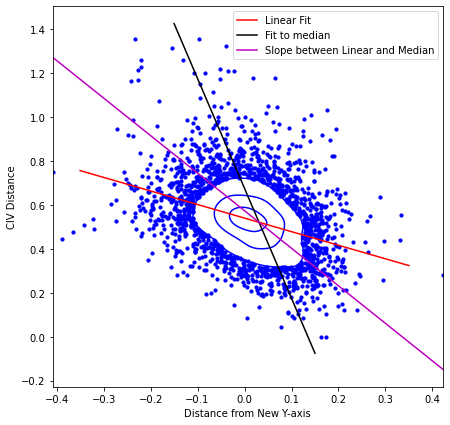

In [217]:
fig = plt.figure(figsize=(7,7))
#plt.scatter(perp_dist_y, CIVdist)
plot_contour(perp_dist_y, CIVdist, c="b", nlevels=3)
plt.plot(x, y, "-r", label="Linear Fit")
#plt.plot(median_perpdist, CIVdist_bins_plot, "--o", c="k", label="median")
plt.plot(x_med, y_med, "-k", label="Fit to median")
#plt.plot(x_avg, y_avg, "-g", label="Avg. of the Fits")
#plt.plot(x_new, y_new, "-m", label="Slope between Linear and Median")
plt.plot(fit_civ_final[:,0], fit_civ_final[:,1], "-m", label="Slope between Linear and Median")
plt.ylabel("CIV Distance")
plt.xlabel("Distance from New Y-axis")
plt.legend(loc="best")
plt.show()

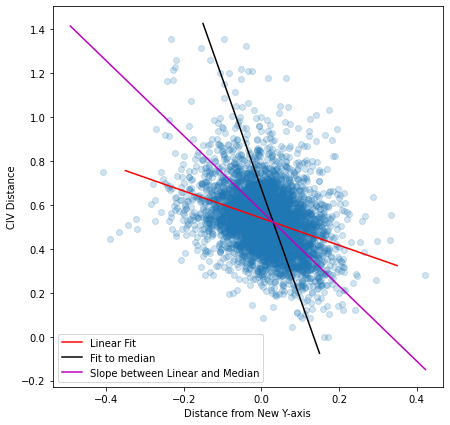

In [222]:
fig = plt.figure(figsize=(7,7))
plt.scatter(perp_dist_y, CIVdist, alpha=0.2)
#plot_contour(perp_dist_y, CIVdist, c="b", nlevels=3)
plt.plot(x, y, "-r", label="Linear Fit")
#plt.plot(median_perpdist, CIVdist_bins_plot, "--o", c="k", label="median")
plt.plot(x_med, y_med, "-k", label="Fit to median")
#plt.plot(x_avg, y_avg, "-g", label="Avg. of the Fits")
#plt.plot(x_new, y_new, "-m", label="Slope between Linear and Median")
plt.plot(fit_civ_final[:,0], fit_civ_final[:,1], "-m", label="Slope between Linear and Median")
plt.ylabel("CIV Distance")
plt.xlabel("Distance from New Y-axis")
plt.legend(loc="best")
plt.show()

Loop through each data point

1) Get index along corresponding to nearest CIV distance of the current data point

2) Using the index, get the distance from the new y-axis we'd expect this point to be shifted

3) Save the expected distance from the axis as the distance to shift 

In [251]:
perp_dist_y_new = []
for i in range(len(CIVdist)):
    ind = abs(fit_civ_final[:,1]-CIVdist[i]).argmin()
    #ind = abs(y_med-CIVdist[i]).argmin()
    dist_shift = fit_civ_final[ind,0]
    perp_dist_y_new.append(perp_dist_y[i]-dist_shift)
perp_dist_y_new = np.array(perp_dist_y_new)   

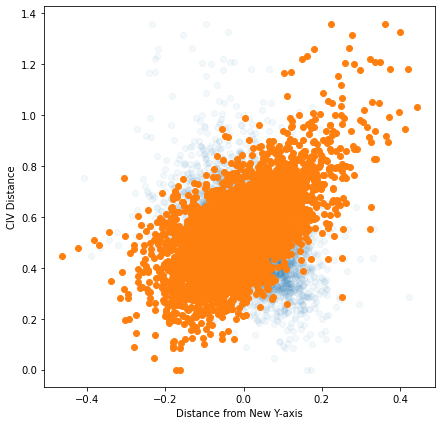

In [252]:
fig = plt.figure(figsize=(7,7))
plt.scatter(perp_dist_y, CIVdist, alpha=0.05)
plt.scatter(perp_dist_y_new, CIVdist)
plt.ylabel("CIV Distance")
plt.xlabel("Distance from New Y-axis")
#plt.legend(loc="best")
plt.show()

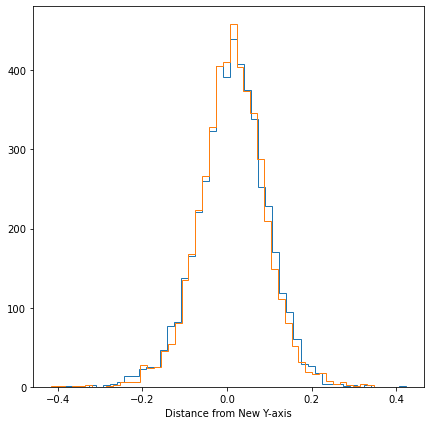

0.013570429339714444


In [250]:
fig = plt.figure(figsize=(7,7))
plt.hist(perp_dist_y, histtype="step", bins="scott")
plt.hist(perp_dist_y_new-0.22, histtype="step", bins="scott")
plt.xlabel("Distance from New Y-axis")
plt.show()
print(np.median(perp_dist_y))

This actually made the spread larger.